# Кластеризация кредитоспособности клиентов немецкого банка

**Цель работы:**  
Исследовать методы кластеризации на примере данных о клиентах немецкого банка и выполнить группировку клиентов по сходным характеристикам.  
В работе используются методы K-means и DBSCAN, а также визуальные и численные критерии выбора числа кластеров и оценки качества разбиения.


In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
    rand_score
)

from sklearn.decomposition import PCA

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.grid'] = True

# Загружаем данные
data_path = 'german_credit_data.csv'
df = pd.read_csv(data_path)

df.head()

,Unnamed: 0,Age,Job,Credit amount,Duration
count,1000.00,1000.00,1000.00,1000.00,1000.00
mean,499.50,35.55,1.90,3271.26,20.90
std,288.82,11.38,0.65,2822.74,12.06
min,0.00,19.00,0.00,250.00,4.00
25%,249.75,27.00,2.00,1365.50,12.00
50%,499.50,33.00,2.00,2319.50,18.00
75%,749.25,42.00,2.00,3972.25,24.00
max,999.00,75.00,3.00,18424.00,72.00


## Описание датасета

Датасет содержит информацию о клиентах немецкого банка и их кредитах.  
Основные признаки:

- Возраст (числовое значение)
- Пол (текст: мужской, женский)
- Должность (числовая система: 0 - неквалифицированный работник, не проживающий в данном регионе, 1 - неквалифицированный работник, проживающий в данном регионе, 2 - квалифицированный работник, 3 - высококвалифицированный работник)
- Жилье (текст: собственное, арендованное или бесплатное)
- Сберегательные счета (текст - небольшой, средний, достаточно большой, богатый)
- Расчетный счет (числовой, в немецких марках)
- Сумма кредита (числовое значение, в немецких марках)
- Продолжительность (числовое значение, в месяцах)
- Назначение (текст: автомобиль, мебель/оборудование, радио/телевизор, бытовая техника, ремонт, образование, бизнес, отдых/другое)

В задаче кластеризации мы будем рассматривать признак *Risk* как дополнительный (внешний) критерий оценки кластеров, но при формировании самих кластеров он использоваться не будет.


**Почему гистограммы строятся только для числовых признаков**  
Гистограмма отображает распределение **количественной** переменной по интервалам значений. Для категориальных признаков (например, “Жильё”, “Цель кредита”) корректнее использовать столбчатые диаграммы частот, а не гистограммы. Поэтому гистограммы строятся только для числовых показателей, где имеет смысл анализ формы распределения, асимметрии и эксцесса.


Числовые признаки: ['Unnamed: 0', 'Age', 'Job', 'Credit amount', 'Duration']
Категориальные признаки: ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']

Итого:
  Числовых: 5
  Категориальных: 6


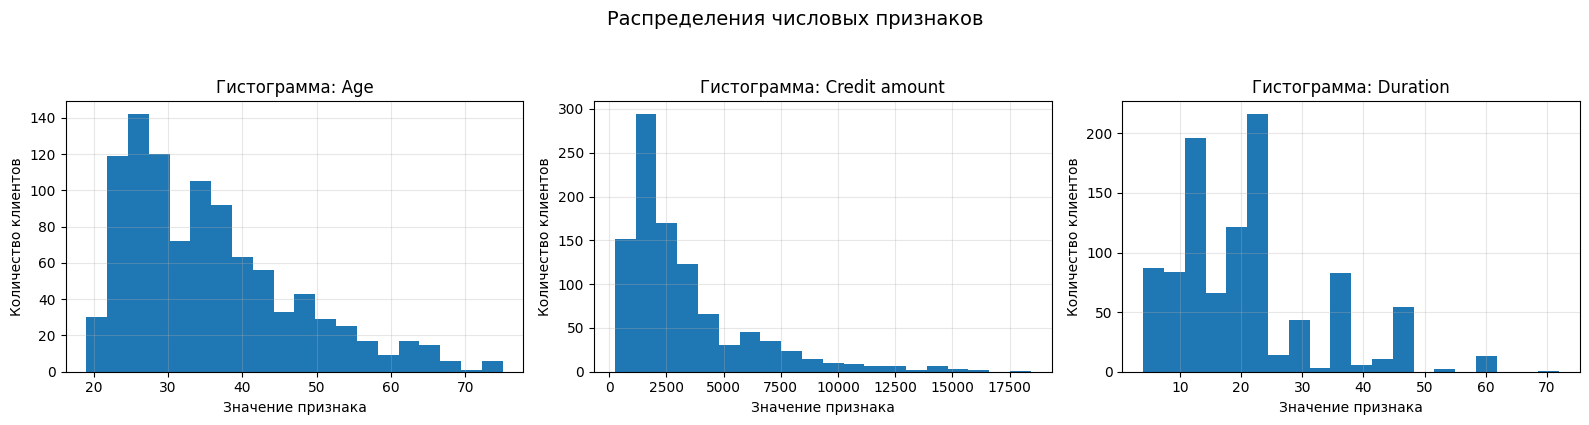

,Признак,Среднее,Медиана,Стандартное отклонение,Асимметрия,Эксцесс
0,Age,35.546,33.0,11.375469,1.020739,0.595780
1,Credit amount,3271.258,2319.5,2822.736876,1.949628,4.292590
2,Duration,20.903,18.0,12.058814,1.094184,0.919781


In [3]:
# Типы признаков
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Числовые признаки:", numeric_cols)
print("Категориальные признаки:", categorical_cols)

print("\nИтого:")
print("  Числовых:", len(numeric_cols))
print("  Категориальных:", len(categorical_cols))

num_for_hist = ['Age', 'Credit amount', 'Duration']

stats_rows = []
fig, axes = plt.subplots(1, len(num_for_hist), figsize=(16, 4))

for ax, col in zip(axes, num_for_hist):
    s = df[col].dropna()
    ax.hist(s, bins=20)
    ax.set_title(f'Гистограмма: {col}')
    ax.set_xlabel('Значение признака')
    ax.set_ylabel('Количество клиентов')
    ax.grid(True, alpha=0.3)

    stats_rows.append({
        "Признак": col,
        "Среднее": s.mean(),
        "Медиана": s.median(),
        "Стандартное отклонение": s.std(),
        "Асимметрия": s.skew(),         # skewness
        "Эксцесс": s.kurtosis()         # excess kurtosis (0 ~ нормальное)
    })

plt.suptitle('Распределения числовых признаков', y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

hist_stats = pd.DataFrame(stats_rows)
hist_stats


**Вывод**

**Типы переменных.**  
В датасете присутствуют два основных типа признаков: **числовые** (по типу возраст, сумма кредита, срок кредита) и **категориальные** (цель кредита, тип жилья, пол, тип счетов).  
Категориальные признаки описывают качественные характеристики клиента и требуют кодирования (one-hot coding) перед использованием в алгоритмах, основанных на расстояниях.

**Выводы по гистограммам**

- **Age (Возраст):**  
  У данной гистограммы явно присутствует "хвост" вправо, который показывает, что молодых клиентов банка больше, чем старших (ассиметрия в данном случае = 1)  
  Эксцесс = 0,6, что означает «пиковое» распределение с более тяжёлыми хвостами (следовательно, выбросы встречаются чаще)

- **Credit amount (Сумма кредита):**  
  Наблюдается **правая асимметрия** (асимметрия = 1,9), следовательно, большинство кредитов относительно небольшие, а большие суммы встречаются реже и формируют хвост вправо.  
  Положительный эксцесс (4,3) указывает на наличие тяжёлых хвостов и потенциальных выбросов по сумме кредита.

- **Duration (Срок кредита):**  
  Распределение имеет правую асимметрию (в сторону больших сроков), что отражает различия в кредитных продуктах.  
  Эксцесс с значением 0,9 помогает определить выраженные хвосты (редкие очень большие сроки), что важно для последующей кластеризации и выбора масштабирования.



**Удаление выбросов перед матрицей рассеяния**  
Матрица диаграмм рассеивания чувствительна к экстремальным значениям: выбросы ухудшают читаемость структуры данных. Поэтому перед построением матрицы распределений выбросы по ключевым числовым признакам удаляются методом IQR.


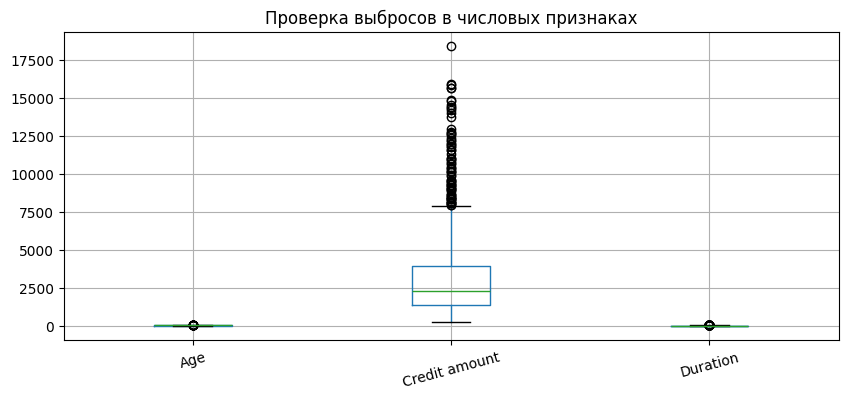

Удалено выбросов (IQR): 138 строк из 1000 (13.80%)


In [4]:
numeric_features = ['Age', 'Credit amount', 'Duration']

# Строим ящик с усами
plt.figure(figsize=(10, 4))
df[numeric_features].boxplot()
plt.title('Проверка выбросов в числовых признаках')
plt.xticks(rotation=15)
plt.show()

# IQR-оценка доли выбросов
outlier_stats = []
for col in numeric_features:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = ((df[col] < lower) | (df[col] > upper)).mean()
    outlier_stats.append([col, outliers])

outlier_df = pd.DataFrame(outlier_stats, columns=['Колонка','Частота выбросов(IQR)'])
outlier_df

df_clean = df.copy()

iqr_cols = num_for_hist
mask = pd.Series(True, index=df_clean.index)

for col in iqr_cols:
    q1 = df_clean[col].quantile(0.25)
    q3 = df_clean[col].quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    mask &= df_clean[col].between(low, high)

before = df_clean.shape[0]
df_clean = df_clean[mask].copy()
after = df_clean.shape[0]

print(f"Удалено выбросов (IQR): {before - after} строк из {before} ({(before-after)/before:.2%})")


**Вывод по выбросам**

Большое количество выбросов наблюдается в признаке "Сумма кредита". Это объясняется тем, что некоторые клиенты (в особенности среднего возраста, с хорошей зарплатой и своим жильём) сильно не ограничены в средствах и могут брать более большие суммы кредита, что и объясняет выбрросы.

Далее построим матрицу корреляций для более визуального представления.

**ВАЖНО:**


Мы строим матрицу ТОЛЬКО для числовых признаков

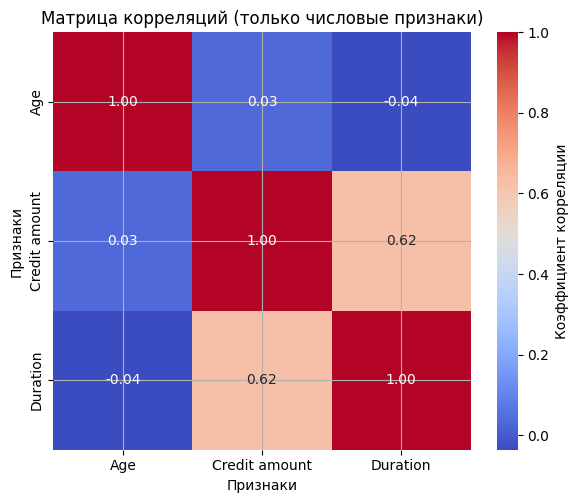

,Признак 1,Признак 2,Корреляция r
2,Credit amount,Duration,0.624984
1,Age,Duration,-0.036136
0,Age,Credit amount,0.032716


In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

num_corr_cols = num_for_hist  # те же 3 признака
corr = df[num_corr_cols].corr(method="pearson")

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt=".2f", square=True, cmap="coolwarm",
            cbar_kws={"label": "Коэффициент корреляции"})
plt.title("Матрица корреляций (только числовые признаки)")
plt.xlabel("Признаки")
plt.ylabel("Признаки")
plt.tight_layout()
plt.show()

# Таблица парных корреляций
pairs = []
for i in range(len(num_corr_cols)):
    for j in range(i+1, len(num_corr_cols)):
        a, b = num_corr_cols[i], num_corr_cols[j]
        pairs.append((a, b, corr.loc[a, b]))
pairs_df = pd.DataFrame(pairs, columns=["Признак 1", "Признак 2", "Корреляция r"]).sort_values("Корреляция r", key=np.abs, ascending=False)
pairs_df


**Вывод по матрице корреляций**  


- **Age <--> Credit amount:**  
  r близок к 0 (0,03) — линейной связи практически нет: суммы кредитов зависят не столько от возраста, сколько от других факторов (доход, цель кредита, статус счетов и т.д.).  

- **Age <--> Duration:**  
  r в данном случае отрицательный (-0,04) => с увеличением возраста незначительно, но падает срок выплаты кредита (обратная зависимость между признаками).

- **Credit amount <--> Duration:**  
  Положительная корреляция между признаками (r = 0,62) означает, что более крупные кредиты чаще берут на более длительный срок.  



## Предобработка данных и масштабирование

Для корректной работы алгоритмов кластеризации, основанных на расстояниях (особенно K-means), необходимо привести числовые признаки к одному масштабу.

Мы будем использовать **StandardScaler**, который вычитает среднее и делит на стандартное отклонение.  
Категориальные признаки закодируем методом **One-Hot Encoding**.

In [6]:
# Удаляем технический столбец
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Целевая переменная для внешней оценки (использоваться в кластеризации не будет)
y_raw = df['Risk']
y = y_raw.map({'good': 0, 'bad': 1})

X = df.drop(columns=['Risk'])

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print('Числовые признаки:', numeric_cols)
print('Категориальные признаки:', categorical_cols)

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

X_scaled = preprocessor.fit_transform(X)

print('Форма матрицы признаков после кодирования и масштабирования:', X_scaled.shape)

Числовые признаки: ['Age', 'Job', 'Credit amount', 'Duration']
Категориальные признаки: ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
Форма матрицы признаков после кодирования и масштабирования: (1000, 26)


**Информационная значимость признаков**

Проведём информационную значимость признаков

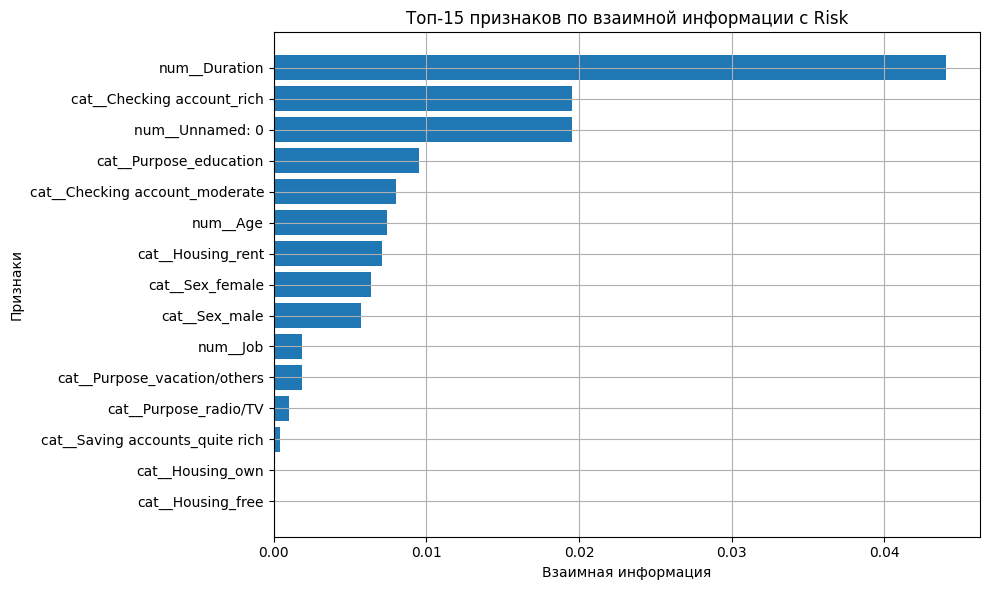

,Признак,Взаимная информация
4,num__Duration,0.044071
16,cat__Checking account_rich,0.019567
0,num__Unnamed: 0,0.019518
20,cat__Purpose_education,0.009522
15,cat__Checking account_moderate,0.008013
1,num__Age,0.007424
9,cat__Housing_rent,0.007086
5,cat__Sex_female,0.006357
6,cat__Sex_male,0.005731
2,num__Job,0.001854


In [7]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

y_risk = df_clean["Risk"].map({"good": 0, "bad": 1})

X_mi = df_clean.drop(columns=["Risk"])

num_cols = X_mi.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_mi.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

mi_preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                          ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat_cols)
    ],
    remainder="drop"
)

X_encoded = mi_preprocessor.fit_transform(X_mi)
X_dense = X_encoded.toarray() if hasattr(X_encoded, "toarray") else X_encoded

mi = mutual_info_classif(X_dense, y_risk, random_state=RANDOM_STATE)

feature_names = mi_preprocessor.get_feature_names_out()
mi_df = pd.DataFrame({"Признак": feature_names, "Взаимная информация": mi}).sort_values("Взаимная информация", ascending=False)

plt.figure(figsize=(10, 6))
topn = 15
plt.barh(mi_df.head(topn)["Признак"][::-1], mi_df.head(topn)["Взаимная информация"][::-1])
plt.title("Топ-15 признаков по взаимной информации с Risk")
plt.xlabel("Взаимная информация")
plt.ylabel("Признаки")
plt.tight_layout()
plt.show()

mi_df.head(15)


**Вывод по информационной значимости признаков**  
На основании расчёта взаимной информации между признаками и целевой переменной *Risk* можно сделать вывод, что наибольший вклад в различие кредитоспособности наиболее информативным признаком оказался тип расчётного счёта клиента, что указывает на важность финансового поведения и уровня ликвидности при оценке кредитного риска. Существенную значимость также демонстрируют срок кредита (*Duration*), а также признаки, связанные с жилищными условиями клиента (аренда или владение жильём).

Числовые признаки, такие как сумма кредита (*Credit amount*) и срок кредитования, обладают умеренной информативностью, что подтверждает их влияние на вероятность возврата кредита, однако не является доминирующим по сравнению с качественными характеристиками клиента. Признаки, связанные с целью кредита, а также отдельные демографические параметры, имеют относительно низкие значения взаимной информации и вносят меньший вклад в объяснение кредитного риска.

В целом полученные результаты подтверждают, что кредитоспособность клиентов определяется совокупностью нескольких факторов, а не одним доминирующим признаком. Это обосновывает применение многомерных методов анализа, в том числе кластеризации, для выявления групп клиентов с различными профилями кредитного риска.


### **Матрица диаграмм рассеивания**

Для предварительной визуальной оценки структуры данных построим матрицу диаграмм рассеивания для числовых признаков.

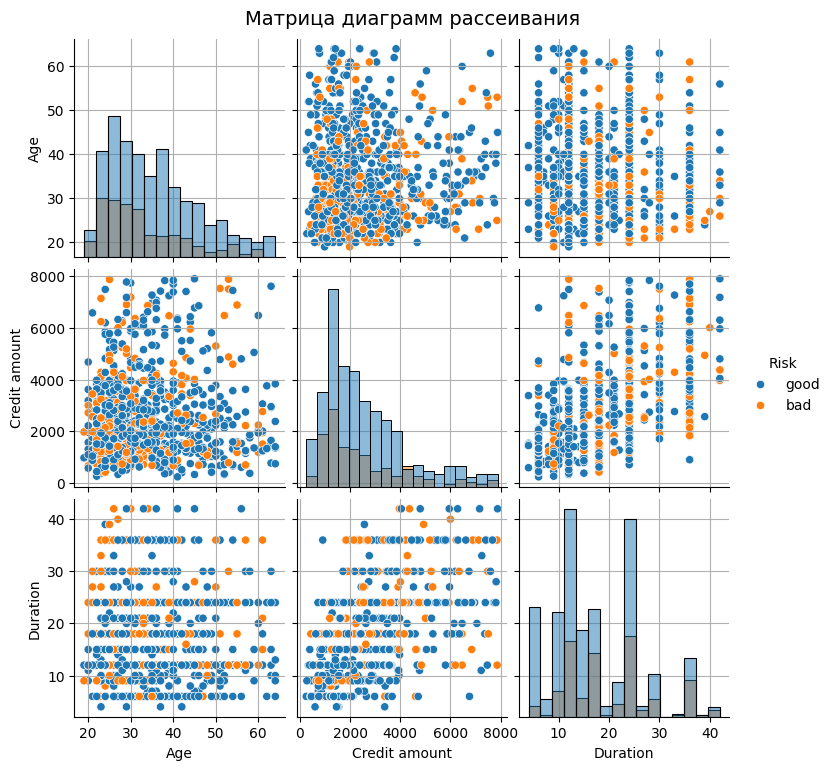

In [8]:
# только числовые + Risk для раскраски
plot_cols = num_for_hist + ["Risk"]

g = sns.pairplot(df_clean[plot_cols], hue="Risk", diag_kind="hist")
g.fig.suptitle("Матрица диаграмм рассеивания", y=1.02, fontsize=14)
plt.show()


**На основе матрицы диаграмм рассеивания можно сделать вывод, что:**

Количество кластеров - 2;
Плотность объектов - высокая (в связи с возрастами и сроком выплат кредита)


**Выбор методов кластеризации**  
Для сравнения были выбраны два подхода:

1) **K-means (K-средних)** — базовый и широко используемый метод, формирующий кластеры вокруг центров (центроидов). Подходит для данных, где ожидаются компактные группы, и позволяет интерпретировать результат через центры кластеров и внутрикластерные расстояния. Число кластеров k подбирается по методу локтя и силуэтному анализу.

2) **DBSCAN** — плотностной алгоритм, который **не требует заранее задавать число кластеров** и умеет выделять **шум/аномалии** (объекты, не принадлежащие плотным областям). Это особенно полезно для финансовых данных, где возможны выбросы и неоднородная плотность распределения клиентов.


## Метод K-means: подбор числа кластеров

Для выбора количества кластеров k используем метод локтя и силуэтный анализ.

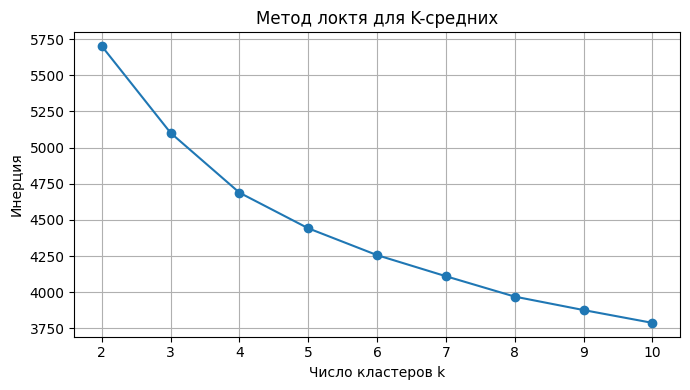

,k,Инерция,Коэффициент силуэта,Коэффициент Калински-Харабас,Коэффициент Дэвиса Болдина
0,2,5701.334746,0.219268,212.747813,1.838914
1,3,5101.318281,0.147713,177.399982,2.057076
2,4,4687.869882,0.140445,157.849002,1.930713
3,5,4441.511417,0.116078,138.625366,2.078510
4,6,4256.067823,0.111847,124.278109,2.146450
5,7,4110.086481,0.104124,113.013808,2.099379
6,8,3969.135282,0.108539,105.240487,2.125792
7,9,3876.169657,0.094852,97.169943,2.189085
8,10,3787.539614,0.087110,90.879304,2.213256


In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

k_values = range(2, 11)
best_k = 3
inertias = []

for k in k_values:
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

# Финальная модель K-means
kmeans = KMeans(
    n_clusters=best_k,
    n_init=10,
    random_state=RANDOM_STATE
)

kmeans_labels = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(7, 4))
plt.plot(list(k_values), inertias, marker='o')
plt.title('Метод локтя для K-средних')
plt.xlabel('Число кластеров k')
plt.ylabel('Инерция')
plt.grid(True)
plt.tight_layout()
plt.show()

# X_scaled — подготовленные данные
k_values = range(2, 11)
rows = []

for k in k_values:
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    labels = km.fit_predict(X_scaled)

    rows.append({
        "k": k,
        "Инерция": km.inertia_,
        "Коэффициент силуэта": silhouette_score(X_scaled, labels),
        "Коэффициент Калински-Харабас": calinski_harabasz_score(X_scaled, labels),
        "Коэффициент Дэвиса Болдина": davies_bouldin_score(X_scaled, labels)  # чем меньше, тем лучше
    })

k_metrics = pd.DataFrame(rows)
k_metrics


**Вывод по методу локтя**  
При увеличении числа кластеров значение инерции уменьшается, так как кластеры становятся «уже». Оптимальное k обычно выбирают в точке перегиба («локтя»), где дальнейшее увеличение k даёт уже небольшое улучшение. Это значение k можно дополнительно подтвердить силуэтным анализом. Предварительно можно сказать, что оптимлаьное число кластеров - k=2 


**Финальный расчёт числа кластеров по коэффициенту силуэта**

In [10]:
best_k = int(k_metrics.loc[k_metrics["Коэффициент силуэта"].idxmax(), "k"])
kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=RANDOM_STATE)
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_centers = kmeans.cluster_centers_

best_k


2

**Также ниже представлен график силуэта для К-средних для большей наглядности**

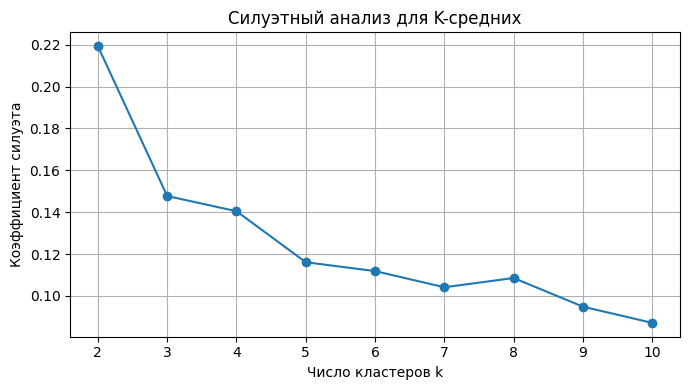

2

In [11]:
sil_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

plt.figure(figsize=(7, 4))
plt.plot(list(k_values), sil_scores, marker='o')
plt.title('Силуэтный анализ для K-средних')
plt.xlabel('Число кластеров k')
plt.ylabel('Коэффициент силуэта')
plt.grid(True)
plt.tight_layout()
plt.show()

best_k = list(k_values)[int(np.argmax(sil_scores))]
best_k


**PCA-график для К-средних**

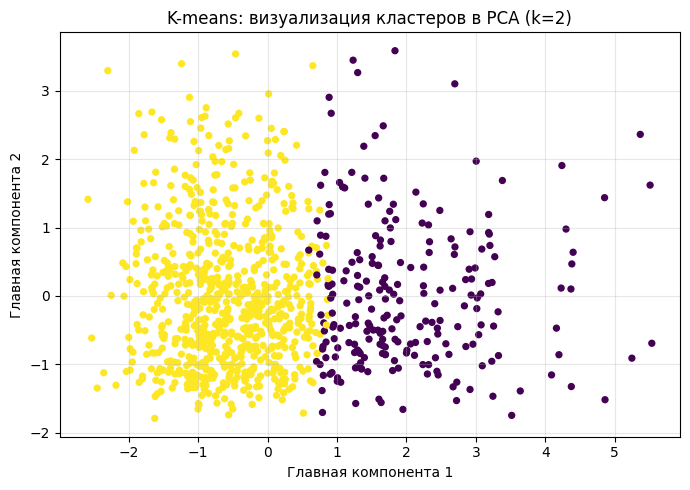

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans_labels, s=18, label="Кластеры")
plt.title(f"K-means: визуализация кластеров в PCA (k={best_k})")
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Рассчитаем расстояния между центрами кластеров

In [13]:
from sklearn.metrics import pairwise_distances

# расстояния между центрами
center_dists = pairwise_distances(kmeans_centers)
center_dists_df = pd.DataFrame(center_dists)
center_dists_df


,0,1
0,0.000000,2.615691
1,2.615691,0.000000


И также рассчитаем внутрикластерные расстояния (среднее до центра)

In [14]:
# внутрикластерные расстояния (среднее расстояние до центра)
from sklearn.metrics import pairwise_distances

dists_to_centers = pairwise_distances(X_scaled, kmeans_centers)
dist_to_own_center = dists_to_centers[np.arange(len(X_scaled)), kmeans_labels]

compactness_km = dist_to_own_center.mean()
compactness_km


np.float64(2.3242980105833193)

## **DBSCAN**

В связи с тем, что предварительный анализ показал высокую плотность между объектами, было принято решение использовать метод DBSCAN, который очень хорошо показывает себя в таких ситуациях.

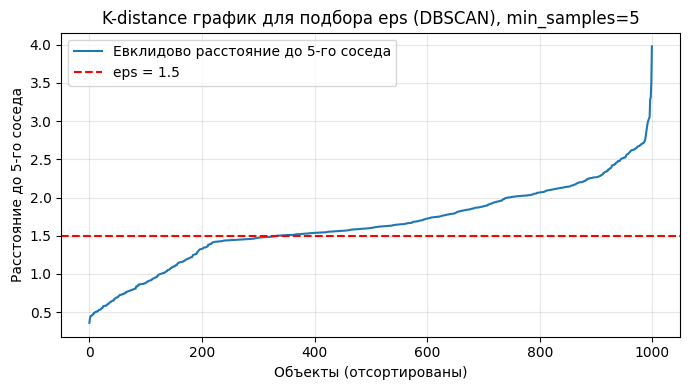

In [16]:
from sklearn.neighbors import NearestNeighbors


min_samples = 5

nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_scaled)
distances, _ = nn.kneighbors(X_scaled)
k_dist = np.sort(distances[:, -1])

plt.figure(figsize=(7,4))
plt.plot(k_dist, label=f"Евклидово расстояние до {min_samples}-го соседа")
plt.axhline(1.5, linestyle="--", label="eps = 1.5", color="red")
plt.title(f"K-distance график для подбора eps (DBSCAN), min_samples={min_samples}")
plt.xlabel("Объекты (отсортированы)")
plt.ylabel(f"Расстояние до {min_samples}-го соседа")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


**Вывод по k-distance графику**  
В данном случае резкий рост `eps` наблюается на отметке в 1,5. Следовательно, это число и возьмём для дальнейших вычислений в DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

# Выбираем eps на основе k-distance
eps = 1.5
db = DBSCAN(eps=eps, min_samples=min_samples)

db_labels = db.fit_predict(X_scaled)

# PCA для визуализации
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7, 5))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=db_labels, s=18)
plt.title(f'DBSCAN в пространстве PCA (eps={eps}, min_samples={min_samples})')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.tight_layout()
plt.show()

# Сколько кластеров и шум
n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise = np.sum(db_labels == -1)
n_clusters, n_noise


Центры как среднее по точкам кластера

In [ ]:
db_centers = []
for lab in sorted(set(db_labels)):
    if lab == -1:
        continue
    idx = np.where(db_labels == lab)[0]
    center = X_scaled[idx].mean(axis=0)
    db_centers.append((lab, len(idx), center))

db_centers_info = pd.DataFrame([(lab, size) for lab, size, _ in db_centers],
                               columns=["Кластер DBSCAN", "Размер кластера"])
db_centers_info


**Вывод по результатам DBSCAN**  
DBSCAN выделяет кластеры как области повышенной плотности и дополнительно помечает часть объектов как шум. На проекции графика видно, как алгоритм группирует точки без явного задания числа кластеров. Если шумовых точек слишком много, обычно стоит уменьшить `eps` или увеличить `min_samples`; если почти все точки в одном кластере — чаще всего нужно увеличить `eps` или уменьшить `min_samples`.


**Метрики качества для DBSCAN и K-средних**

Ниже представлены расчитанные внутренние и внешние метрики для каждого использованного нами метода (К средние и DBSCAN)

In [ ]:
# Внутренние метрики
def safe_internal_metrics(X, labels):
    # минимум 2 кластера без учёта шума
    if len(set(labels) - {-1}) < 2:
        return np.nan, np.nan, np.nan
    mask = labels != -1
    if mask.sum() < 2 or len(set(labels[mask])) < 2:
        return np.nan, np.nan, np.nan
    return (
        silhouette_score(X[mask], labels[mask]),
        calinski_harabasz_score(X[mask], labels[mask]),
        davies_bouldin_score(X[mask], labels[mask])
    )

sil_km = silhouette_score(X_scaled, kmeans_labels)
ch_km = calinski_harabasz_score(X_scaled, kmeans_labels)
dbi_km = davies_bouldin_score(X_scaled, kmeans_labels)

sil_db, ch_db, dbi_db = safe_internal_metrics(X_scaled, db_labels)

internal_df = pd.DataFrame([
    {"Метод": f"K-means (k={best_k})", "Коэффициент силуэта": sil_km, "Калински-Харабас": ch_km, "Дэвис Болдин": dbi_km},
    {"Метод": f"DBSCAN (eps={eps})", "Коэффициент силуэта": sil_db, "Калински-Харабас": ch_db, "Дэвис Болдин": dbi_db},
])

internal_df



In [ ]:
# Внешние метрики
y_true = df["Risk"].map({"good": 0, "bad": 1}).to_numpy()

def pairwise_jaccard(true_labels, cluster_labels):
    n = len(true_labels)
    same_true = (true_labels[:, None] == true_labels[None, :])
    same_cl = (cluster_labels[:, None] == cluster_labels[None, :])
    # исключим диагональ
    np.fill_diagonal(same_true, False)
    np.fill_diagonal(same_cl, False)
    inter = np.logical_and(same_true, same_cl).sum()
    union = np.logical_or(same_true, same_cl).sum()
    return inter / union if union > 0 else np.nan

# Для DBSCAN внешние метрики считаем без шума (-1)
mask_db = db_labels != -1
ari_km = adjusted_rand_score(y_true, kmeans_labels)
rand_km = rand_score(y_true, kmeans_labels)
jac_km = pairwise_jaccard(y_true, kmeans_labels)

ari_db = adjusted_rand_score(y_true[mask_db], db_labels[mask_db]) if mask_db.sum() > 0 else np.nan
rand_db = rand_score(y_true[mask_db], db_labels[mask_db]) if mask_db.sum() > 0 else np.nan
jac_db = pairwise_jaccard(y_true[mask_db], db_labels[mask_db]) if mask_db.sum() > 0 else np.nan

external_df = pd.DataFrame([
    {"Метод": "K-means", "Rand": rand_km, "ARI": ari_km, "Индекс Жаккара": jac_km},
    {"Метод": "DBSCAN (без шума)", "Rand": rand_db, "ARI": ari_db, "Индекс Жаккара": jac_db},
])
external_df

**Исследование влияния параметров DBSCAN (eps и/или min_samples)**

In [ ]:
eps_values = np.linspace(0.3, 1.5, 7)
stats = []

for e in eps_values:
    db = DBSCAN(eps=float(e), min_samples=min_samples)
    labels = db.fit_predict(X_scaled)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = np.sum(labels == -1)

    sil, ch, dbi = safe_internal_metrics(X_scaled, labels)
    stats.append([float(e), n_clusters, int(n_noise), sil])

stats_df = pd.DataFrame(stats, columns=["eps", "n_clusters", "n_noise", "silhouette"])


plt.figure(figsize=(7,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=db_labels, s=18)
plt.title(f'DBSCAN в пространстве PCA (eps={eps}, min_samples={min_samples})')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.tight_layout()
plt.show()

stats_df


**Вывод по влиянию параметра eps**  
При изменении eps меняется плотностной порог объединения точек: при слишком малом eps (0,8) возрастает доля шума и число кластеров может стать слишком большим; при слишком большом eps (7 к примеру) кластеры сливаются и алгоритм может выделить один крупный кластер.

**Отдельный графики KMeans и DBSCAN в PCA**

In [ ]:

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, s=18)
plt.title(f'K-means в пространстве PCA (k={best_k})')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=db_labels, s=18)
plt.title(f'DBSCAN в пространстве PCA (eps={eps}, min_samples={min_samples})')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.tight_layout()
plt.show()


**Вывод по сравнению визуализаций**  
На проекции PCA можно сравнить характер разбиения: K-means формирует кластеры вокруг центров (и всегда создаёт ровно k групп), а DBSCAN выделяет кластеры как плотные области и может оставлять часть объектов как шум. Для данных кредитной тематики DBSCAN может быть полезен тем, что отдельно выявляет «нетипичных» клиентов (шумовые точки), которые потенциально соответствуют выбросам/аномалиям.


## Заключение

В лабораторной работе была проведена кластеризация клиентов немецкого банка на основе их социально-демографических и финансовых характеристик.  
Были реализованы два метода кластеризации — K-means и DBSCAN, а также выполнен подбор числа кластеров с использованием метода локтя и силуэтного анализа.

Для оценки качества кластеризации использовались внутренние метрики, а также внешние метрики, основанные на сравнении кластеров с известной меткой кредитоспособности.  
Сравнение результатов показало, что оба метода выделяют сходные группы клиентов, однако численные значения метрик и визуальный анализ кластеров позволяют сделать вывод о различиях в форме и компактности полученных групп.

Интерпретация центров кластеров K-means показала, что выделенные группы соответствуют различным типам клиентов: условно более надёжные (good) и более рискованные (bad) с различиями в возрасте, сумме и сроке кредита, а также типах счетов и целей кредитования.  
В целом методы кластеризации демонстрируют применимость для предварительного сегментирования клиентов и могут служить основой для более сложных моделей кредитного скоринга и таргетированных продуктов банка.
